In [9]:
import matplotlib as plt
import math


In [10]:
class Value:

    def __init__(self,data,_children=(),_op = '',label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda:None
        self.grad = 0.0

    def __repr__(self):
        return f"Value(data = {self.data})"

    def __add__(self,other):
        if not isinstance(other, Value):
             other = Value(other)
        out = Value(self.data+other.data,(self,other),'+')
        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*self.grad
        out._backward = _backward
        return out

    def __radd__(self,other):
        return self + other

    def __neg__(self):
        return self*(-1.0)

    def __sub__(self,other):
        return self + (-other)
    def __rsub__(self,other):
        return self - other
        
    def __mul__(self,other):
        if not isinstance(other, Value):
             other = Value(other)
             
                
        out = Value(self.data*other.data,(self,other),'*')
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad

        out._backward = _backward
        return out
        
    def __pow__(self,other):
        assert isinstance(other,(int,float)), 'only supports int/float'
        x = self.data ** other
        out = Value(x,(self,),'**')
        def _backward():
            self.grad = other * (self.data **(other - 1))*out.grad

        out._backward = _backward
        return out
        
        
    def __truediv__(self,other):
        return self*(other**-1)
        
    def __rmul__(self,other):
        return self*other

    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')
        def _backward():
            self.grad += (1-t**2)*out.grad

        out._backward = _backward
        return out

    def backward(self):
                # MY ATTEMPT logic...
        # def backpropogation(L,arr = []):
        #     for i in L._prev:
        #         backpropogation(i,arr)
        
        #     arr.append(L)
        
        
        # def backprop(L):
        #     arr = []
        #     L.grad = 1
        #     backpropogation(L,arr)
        #     print(arr)
        #     while arr:
        #         ele = arr[-1]
        #         ele._backward()
        #         arr.pop()
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)

                topo.append(v)

        build_topo(self)
        self.grad = 1
        for node in reversed(topo):
            node._backward()
            

    
        

In [11]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={'rankdir':'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid,label = "{ %s | data %.4f| grad %.4f}"%(n.label,n.data,n.grad),shape='record')
        if n._op:
            dot.node(name = uid+n._op,label = n._op)
            dot.edge(uid + n._op,uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)),str(id(n2))+n2._op)

    return dot
                

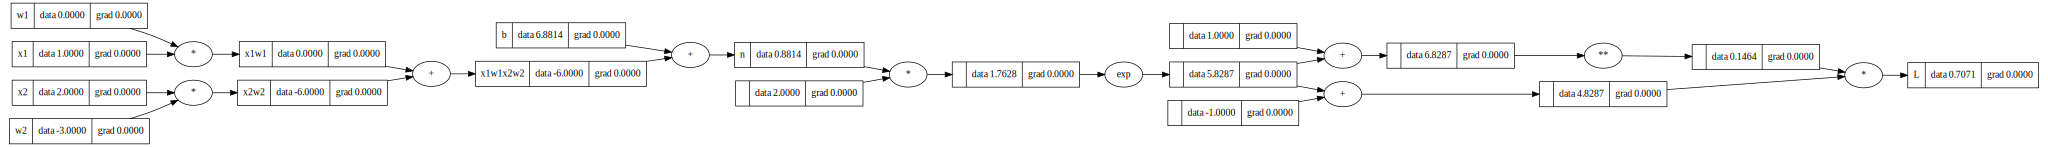

In [12]:
draw_dot(L)

In [13]:
a = Value(4.0)
b = Value(2.2)
a+4

Value(data = 8.0)

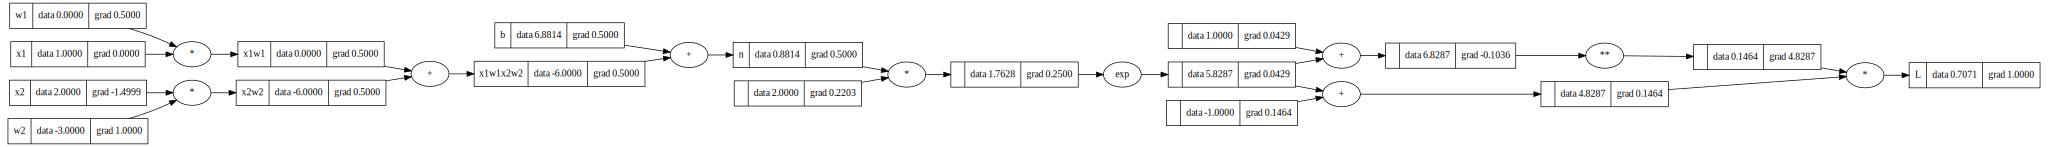

In [14]:
L.backward()
draw_dot(L)

In [15]:
import random

In [16]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return [weight for weight in self.w] + [self.b]

class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [i for n in self.neurons for i in n.parameters()]

class MLP:
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)

        return x 

    def parameters(self):
        return [i for l in self.layers for i in l.parameters()]

  

In [98]:
n = MLP(3,[2,3,1])


X = [[0.1,0.2,0.3],[0.4,0.5,0.6],[0.7,0.8,0.9]]
y = [1,-1,-1]

for k in range(10):
    for i in n.parameters():
        i.grad = 0.0
    
    y_pred = [n(x) for x in X]
    loss = sum((yi - yi_pred)**2 for yi,yi_pred in zip(y,y_pred))
    loss.backward()
    for i in n.parameters():
        i.data += -0.1*i.grad

    print(loss)



Value(data = 3.8086955597206718)
Value(data = 3.047791460507339)
Value(data = 2.40757803557392)
Value(data = 2.774435596690582)
Value(data = 2.500331485939864)
Value(data = 2.5783213271949417)
Value(data = 2.520051164268401)
Value(data = 2.64189269649932)
Value(data = 3.3467839029231126)
Value(data = 3.599400962315492)


In [40]:
# Example y and y_pred
y = [3, 4.5, 2, 5]
y_pred = [n(x) for x in X]

# Calculate loss
print(y_pred)


[[Value(data = -0.9657045031779945), Value(data = 0.738668709871364), Value(data = 0.9787240282171399)], [Value(data = -0.9664898365228596), Value(data = 0.7388935178225459), Value(data = 0.9792769100581495)], [Value(data = -0.9667467172599945), Value(data = 0.7389649677100396), Value(data = 0.9794572289328252)]]


In [99]:
for k in range(100):   #Gradient Descent
    for i in n.parameters():
        i.grad = 0.0
    
    y_pred = [n(x) for x in X]
    loss = sum((yi - yi_pred)**2 for yi,yi_pred in zip(y,y_pred))
    loss.backward()
    for i in n.parameters():
        i.data += -0.1*i.grad

    print(loss)
    

Value(data = 3.242088555794792)
Value(data = 2.705220554138914)
Value(data = 3.077940317703166)
Value(data = 3.0437515989730524)
Value(data = 2.700169608554367)
Value(data = 3.0356774751026556)
Value(data = 2.9714242178666415)
Value(data = 2.5440467809706417)
Value(data = 2.53748929715284)
Value(data = 2.5283651651616306)
Value(data = 2.7390768613115424)
Value(data = 2.5825910218376364)
Value(data = 2.6272548136635887)
Value(data = 2.6101995852334827)
Value(data = 2.570936680109002)
Value(data = 2.589934783525189)
Value(data = 2.5539050228776423)
Value(data = 2.5617317695469493)
Value(data = 2.6034308364633296)
Value(data = 2.5606756033045412)
Value(data = 2.598139748746919)
Value(data = 2.5407784939332028)
Value(data = 3.3516808157032054)
Value(data = 3.6792887490323687)
Value(data = 3.441674894066176)
Value(data = 3.0186702598022928)
Value(data = 2.6839283649814454)
Value(data = 3.078146633090493)
Value(data = 3.0897913469228935)
Value(data = 2.535673429125947)
Value(data = 2.4957971

In [102]:
[ n(x) for x in X] #result after training 

[Value(data = 0.9401524231182203),
 Value(data = -0.9482231191779856),
 Value(data = -0.967741526658819)]